In [1]:
import scanpy as sc
from torch.utils import data
import torch.optim as optim
import warnings 

In [2]:
warnings.filterwarnings("ignore")

In [3]:
from scInferCode.utils import *
from scInferCode.model import *

In [4]:
rna = sc.read_h5ad('./scInferData/PancreasTask/wt.h5ad')
protein = sc.read_h5ad('./scInferData/PancreasTask/protein.h5ad')

In [5]:
rna.obs['celltype'] = rna.obs['cell_type']

In [6]:
sample_df = make_paired_samples(rna, protein)

Counts of all celltype:
              count
celltype          
alpha            7
beta_1         627
beta_2         113
delta           15
vasculature     48
neg_samples:75000, pos_samples:52644


In [7]:
train_dataset, valid_dataset, rna_df, protein_df = make_scInfer_dataset(rna, protein, sample_df, rna_vars='highly_variable', protein_vars='importance', test_size=0.3, random_state=2024)

In [8]:
input_size = train_dataset.get_size()
batch_size = 2048
hidden_size = 256
embedding_size = 32
num_epochs = 100
margin = 1.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
model = ContrastiveNetwork(input_size, hidden_size, embedding_size).to(device)
criterion = ContrastiveLoss(margin)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=batch_size, shuffle=False)

lr: 0.000900
epoch:0| Train Loss: 3.17322893905186e-05 | Test Loss: 1.4773567325889445e-05
epoch:1| Train Loss: 7.942978597064224e-06 | Test Loss: 5.5472944800540065e-06
epoch:2| Train Loss: 4.028317867191931e-06 | Test Loss: 3.344453870763746e-06
epoch:3| Train Loss: 2.6397194627882984e-06 | Test Loss: 2.3607935405453984e-06
epoch:4| Train Loss: 1.912230094681089e-06 | Test Loss: 1.8607508815774787e-06
epoch:5| Train Loss: 1.4669578324400919e-06 | Test Loss: 1.5771404606625637e-06
epoch:6| Train Loss: 1.1352520025891336e-06 | Test Loss: 1.3501368516641396e-06
epoch:7| Train Loss: 8.975874481980168e-07 | Test Loss: 1.143926008981286e-06
epoch:8| Train Loss: 7.217069545778471e-07 | Test Loss: 9.974938564488143e-07
epoch:9| Train Loss: 5.505698550363276e-07 | Test Loss: 8.298692786389511e-07
lr: 0.000810
epoch:10| Train Loss: 4.2971623847787447e-07 | Test Loss: 7.427754845893753e-07
epoch:11| Train Loss: 3.424967490876678e-07 | Test Loss: 6.501920023701912e-07
epoch:12| Train Loss: 2.688

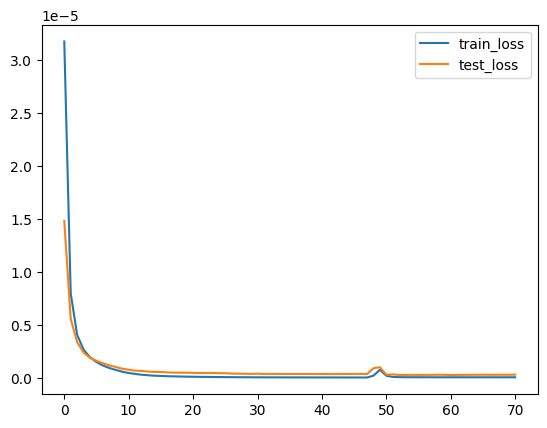

In [29]:
model = train_embeddings(num_epochs, optimizer, device, model, criterion, train_loader, test_loader)

In [11]:
model_path = f'./scInferData/ModelParams/PancreasTask2025.pth'

In [31]:
torch.save(model.state_dict(), model_path)

In [12]:
model = ContrastiveNetwork(input_size, hidden_size, embedding_size).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

ContrastiveNetwork(
  (protein_branch): Sequential(
    (0): Linear(in_features=112, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (rna_branch): Sequential(
    (0): Linear(in_features=2851, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
)

In [14]:
rna_em_ann, protein_em_ann = make_embeddings(model, device, rna_df, protein_df, rna, protein, celltype = 'celltype')

In [15]:
import anndata as ad
import scanpy as sc

In [18]:
rna_em_ann.write('./scInferData/PancreasTask/rna_wt_embeddings.h5ad')
protein_em_ann.write('./scInferData/PancreasTask/protein_embeddings.h5ad')

In [19]:
gko = sc.read_h5ad('./scInferData/PancreasTask/gko.h5ad')

In [20]:
gko.obs['celltype'] = gko.obs['cell_type']

In [21]:
gko_df= make_unlabeled_dataframe(rna, gko, rna_vars='highly_variable')

In [22]:
gko_em_ann, _ = make_embeddings(model, device, gko_df, protein_df, gko, protein)

In [24]:
gko_em_ann_target = gko_em_ann[(gko_em_ann.obs['celltype'] == 'alpha')  | (gko_em_ann.obs['celltype'] == 'beta') | (gko_em_ann.obs['celltype'] == 'delta')]

In [25]:
gko_em_ann_target

View of AnnData object with n_obs × n_vars = 3387 × 32
    obs: 'celltype'

In [38]:
gko_em_ann_target.write('./scInferData/PancreasTask/gko_embeddings.h5ad')